Visualización de muestra biológica translúcida mediante contraste de fase

Campo de visión (Object Size) físico: 390.18 µm
Este campo de visión se mapeará a 720 píxeles.
Pupila Zernike creada: radio_spot=0.18 mm, atenuación=0.8, desfase=1.57 rad


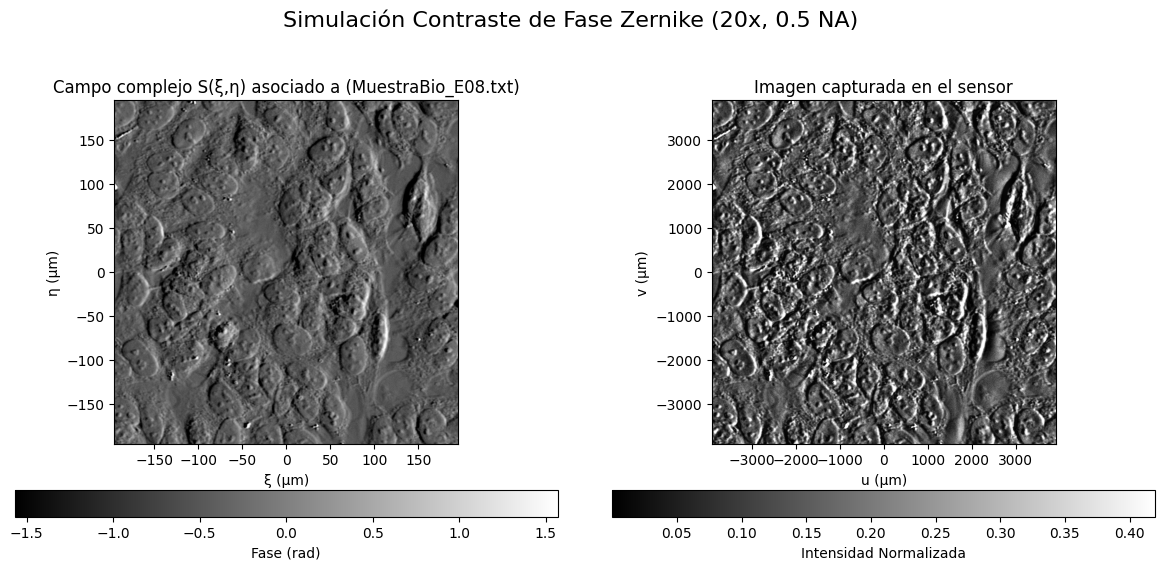

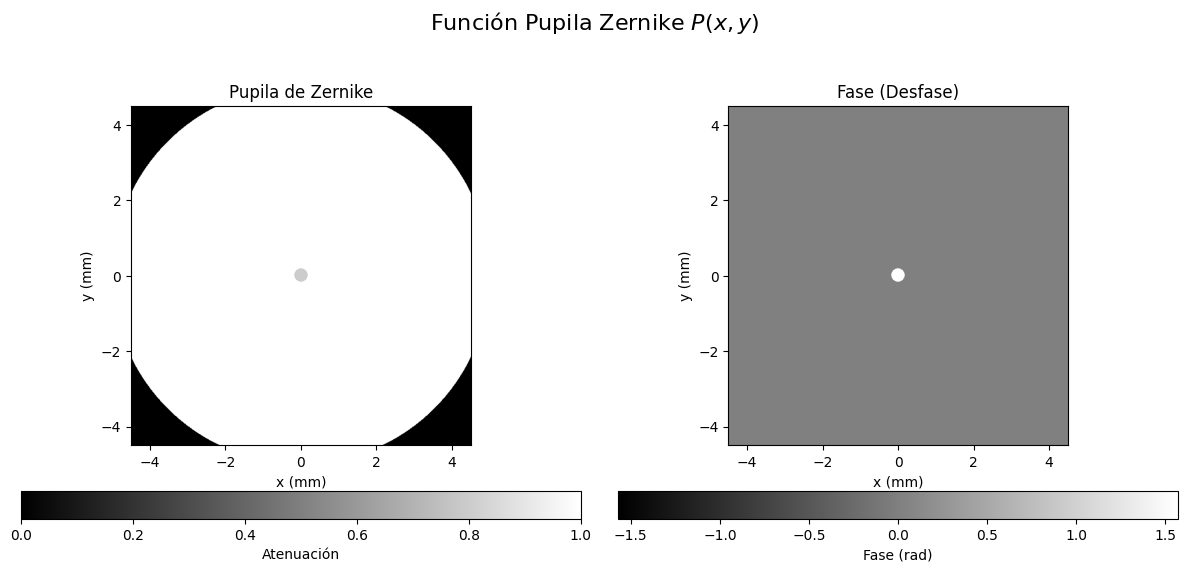

In [20]:
import numpy as np
import matplotlib.pyplot as plt
import os
import io

def load_transmittance(image_path):
    """Carga un archivo (TXT o CSV) que contiene datos complejos."""

    t_xy = None # Campo complejo final

    try:
        # Cargar datos directamente como complejos, delimitados por coma
        t_xy = np.loadtxt(image_path, dtype=np.complex128, delimiter=',')

    except Exception as e:
        # Error simplificado si numpy no puede leer el archivo
        raise IOError(f"Error al cargar TXT/CSV como complejo. Error: {e}")

    return t_xy

def create_zernike_pupil_mask(pixel_count, pupil_plane_size_m, pupil_radius_m, pupil_config):
    """
    Pupila de Contraste de Fase Zernike.

    pupil_config (dict): Contiene los parámetros del filtro Zernike.
        'spot_radius_fraction' (float): Radio del punto de fase como fracción del radio de la pupila.
        'attenuation' (float): Factor de atenuación de amplitud en el punto.
        'phase_shift' (float): Desfase en radianes.
    """
    spot_radius_fraction = pupil_config.get('spot_radius_fraction', 0.1)
    attenuation = pupil_config.get('attenuation', 0.25)
    phase_shift_rad = pupil_config.get('phase_shift', np.pi / 2.0)

    # 1. Crear rejilla de coordenadas de la pupila
    pupil_coords = np.linspace(-pupil_plane_size_m/2, pupil_plane_size_m/2, pixel_count)
    X_p, Y_p = np.meshgrid(pupil_coords, pupil_coords)
    R_p_grid = np.sqrt(X_p**2 + Y_p**2)

    # 2. Empezar con la pupila de campo claro (Apertura)
    pupil_function = np.zeros((pixel_count, pixel_count), dtype=complex)
    pupil_function[R_p_grid < pupil_radius_m] = 1.0 + 0.0j

    # 3. Definir el "punto" de fase Zernike
    spot_radius_m = spot_radius_fraction * pupil_radius_m
    spot_mask = R_p_grid < spot_radius_m

    # 4. Calcular el valor complejo del punto de fase
    spot_value = attenuation * np.exp(1j * phase_shift_rad)

    # 5. Sobrescribir el centro de la pupila con el valor del punto
    final_spot_mask = spot_mask & (R_p_grid < pupil_radius_m)
    pupil_function[final_spot_mask] = spot_value

    print(f"Pupila Zernike creada: radio_spot={spot_radius_m*1e3:.2f} mm, atenuación={attenuation}, desfase={phase_shift_rad:.2f} rad")

    return pupil_function


def simulate_system(input_object, object_size_m, pixel_count, wavelength, f_MO, f_TL, pupil_radius_m,
                    pupil_config):
    """Simula la formación de imagen en un sistema 4f (microscopio)
    con contraste de fase Zernike."""

    # 1. Calcular la escala del plano de la pupila (Plano de Fourier)
    dx_object = object_size_m / pixel_count
    pupil_plane_size_m = (wavelength * f_MO) / dx_object

    # 2. Crear la pupila Zernike
    pupil_function = create_zernike_pupil_mask(
        pixel_count, pupil_plane_size_m, pupil_radius_m, pupil_config
    )

    # 3. Simular la propagación y el filtrado

    # Etapa 1: Objeto -> Plano Focal (Pupila)
    object_spectrum = np.fft.fft2(np.fft.ifftshift(input_object))

    # Etapa 2: Filtrado Espacial
    filtered_spectrum = object_spectrum * np.fft.fftshift(pupil_function)

    # Etapa 3: Plano Focal (Pupila) -> Plano Imagen (Cámara)
    output_field = np.fft.fftshift(np.fft.ifft2(filtered_spectrum))

    # 4. Calcular magnificación y escala de la imagen final
    magnification = f_TL / f_MO
    image_plane_size_m = object_size_m * magnification

    return output_field, image_plane_size_m, pupil_function, pupil_plane_size_m


# Parámetros del Sistema Físico
wavelength = 533e-9      # Longitud de onda (533 nm)
f_mo = 0.01              # Focal Objetivo (10 mm)
f_tl = 0.2               # Focal Lente de Tubo (200 mm)
na_mo = 0.5              # Apertura Numérica del objetivo (0.5)

magnification = f_tl / f_mo # Magnificación (20x)

# Parámetros Físicos del Sensor
dx_sensor = 2.74e-6 # pixel size (2.74 µm)
pixel_count_sensor = 2848  # N


# Cargar el Objeto de Prueba
filename = 'MuestraBio_E08.txt'

# Cargar el objeto complejo desde el TXT
U0_data = load_transmittance(filename)
pixel_count = U0_data.shape[0]


# Calcular tamaños físicos
sensor_size_m = pixel_count_sensor * dx_sensor
object_size_m = sensor_size_m / magnification
pupil_radius_m = na_mo * f_mo

print(f"Campo de visión (Object Size) físico: {object_size_m * 1e6:.2f} µm")
print(f"Este campo de visión se mapeará a {pixel_count} píxeles.")

U0 = U0_data


# Configuración de Pupila Zernike --> Importante, variar parámetros acá

zernike_config = {
    'spot_radius_fraction': 0.035,  # 10% de la pupila
    'attenuation': 0.8,          # 25% de transmisión de amplitud
    'phase_shift': np.pi / 2
}


output_field, image_plane_size_m, pupil_mask, pupil_plane_size_m = simulate_system(
    U0, object_size_m, pixel_count, wavelength, f_mo, f_tl, pupil_radius_m,
    pupil_config=zernike_config
)

# Detección de la Imagen (Intensidad)
intensity = np.abs(output_field)**2
intensity = intensity / np.max(intensity)

# Resultados

output_dir = "output_imagenes_zernike"
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

# Extensión del objeto
extent_obj_um = [-object_size_m/2 * 1e6, object_size_m/2 * 1e6, -object_size_m/2 * 1e6, object_size_m/2 * 1e6]

# Guardar campo - objeto original TXT
plt.figure(figsize=(6, 5))
plt.imshow(np.angle(U0), cmap='gray', extent=extent_obj_um)
plt.title(f'Campo complejo S(ξ,η) asociado a ({filename})')
plt.xlabel('ξ (μm)')
plt.ylabel('η (μm)')
plt.colorbar(label='Fase (rad)')

plt.tight_layout()
plt.savefig(os.path.join(output_dir, "fig0_objeto.png"), dpi=300)
plt.close() # Cerrar la figura para que no se muestre


# --- Figura 1: Comparación Objeto (Fase) vs Imagen (Intensidad) ---
plt.figure(figsize=(12, 6))
plt.suptitle(f"Simulación Contraste de Fase Zernike ({magnification:.0f}x, {na_mo} NA)", fontsize=16)

# Subplot 1: Fase del Objeto Original
plt.subplot(1, 2, 1)
plt.imshow(np.angle(U0), cmap='gray', extent=extent_obj_um)
plt.title(f'Campo complejo S(ξ,η) asociado a ({filename})')
plt.xlabel('ξ (μm)')
plt.ylabel('η (μm)')
plt.colorbar(label='Fase (rad)', orientation='horizontal', pad=0.1)


# Subplot 2: Imagen en el sensor

extent_cam_um = [-image_plane_size_m/2 * 1e6, image_plane_size_m/2 * 1e6, -image_plane_size_m/2 * 1e6, image_plane_size_m/2 * 1e6]
plt.subplot(1, 2, 2)
plt.imshow(intensity, cmap='gray', extent=extent_cam_um, vmax=0.42)
plt.title('Imagen capturada en el sensor')
plt.xlabel('u (μm)')
plt.ylabel('v (μm)')
plt.colorbar(label='Intensidad Normalizada', orientation='horizontal', pad=0.1)


plt.tight_layout(rect=[0, 0.04, 1, 0.95])
plt.savefig(os.path.join(output_dir, "fig1_campo_vs_imagen.png"), dpi=300)
plt.show()

# Detalles de la Pupila Zernike
plt.figure(figsize=(12, 6))
plt.suptitle('Función Pupila Zernike $P(x,y)$', fontsize=16)

# Coordenadas y zoom de la pupila
extent_pup_mm = [-pupil_plane_size_m/2 * 1000, pupil_plane_size_m/2 * 1000, -pupil_plane_size_m/2 * 1000, pupil_plane_size_m/2 * 1000]
zoom_limit_mm = pupil_radius_m * 0.9 * 1000 # Zoom

# Subplot
plt.subplot(1, 2, 1)
plt.imshow(np.abs(pupil_mask), cmap='gray', extent=extent_pup_mm, vmin=0, vmax=1)
plt.title('Pupila de Zernike')
plt.xlabel('x (mm)')
plt.ylabel('y (mm)')
plt.xlim(-zoom_limit_mm, zoom_limit_mm)
plt.ylim(-zoom_limit_mm, zoom_limit_mm)
plt.colorbar(label='Atenuación', orientation='horizontal', pad=0.1)

# Subplot 2: Fase de la Pupila
plt.subplot(1, 2, 2)
plt.imshow(np.angle(pupil_mask), cmap='gray', extent=extent_pup_mm, vmin=-np.pi/2, vmax=np.pi/2)
plt.title('Fase (Desfase)')
plt.xlabel('x (mm)')
plt.ylabel('y (mm)')
plt.xlim(-zoom_limit_mm, zoom_limit_mm)
plt.ylim(-zoom_limit_mm, zoom_limit_mm) # Corregido
plt.colorbar(label='Fase (rad)', orientation='horizontal', pad=0.1)

plt.tight_layout(rect=[0, 0.04, 1, 0.95])
plt.savefig(os.path.join(output_dir, "fig2_pupila_zernike.png"), dpi=300)
plt.show()
